Em ciência de dados, escolhas na implementação de código podem ter impactos na eficiência de esteiras analíticas. Uma dessas escolhas recorrentes é entre utilizar o método .apply() com funções definidas linha a linha ou optar por abordagens vetorizadas como numpy.select(). Embora ambas conduzam ao mesmo resultado lógico, o custo computacional entre elas pode ser distinto, especialmente em grandes volumes de dados.

Neste experimento, foi conduzida uma avaliação sistemática de performance comparando essas duas abordagens, aplicando uma lógica de classificação sobre um conjunto de dados com diferentes comprimentos (N). O experimento consistiu em atribuir uma categoria a cada valor da coluna Value, de acordo com faixas numéricas: valores acima de 1000 seriam classificados como "High", entre 501 e 1000 como "Medium", e até 500 como "Low".

A primeira abordagem utilizou o método .apply(), que aplica uma função Python sobre cada linha do DataFrame. Essa técnica opera sob uma lógica iterativa interna, típica do interpretador Python, que ignora as otimizações vetoriais do NumPy e do Pandas. Como resultado, seu desempenho degrada severamente à medida que o volume de dados cresce.

A segunda abordagem empregou a função numpy.select(), uma técnica vetorizada que avalia todas as condições de uma só vez, em blocos. Essa estratégia se alinha à arquitetura do Pandas, que é construída sobre arrays NumPy otimizados em C. Por isso, oferece ganhos substanciais de performance, sobretudo quando aplicada a datasets com milhões de registros.

Os testes foram realizados em DataFrames com tamanhos variando de centenas a um milhão de linhas. Em cada cenário, o tempo de execução foi medido para ambas as abordagens. Algumas ressalvas do experimento, devido à problemas de memória, não foi possível realizar o test com N maior que 10^6 linhas, e nesta escala de testes, os dois métodos se mostraram com performance estatisticamente semelhantes. Talvez em uma escala maior (N >> 10^6) a hipótese de que o método do Numpy tenha de fato uma performance melhor.

Abaixo o gráfico demonstrando o resultado do teste, e o código do experimento

In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

def generate_dataframe(n_rows: int = 1_000_000, seed: int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    return pd.DataFrame({'Value': np.random.randint(0, 2000, size=n_rows)})

def method_apply(df: pd.DataFrame) -> float:
    def classify(value: int) -> str:
        if value > 1000:
            return 'High'
        elif value > 500:
            return 'Medium'
        else:
            return 'Low'
    start = time.perf_counter()
    df['FeatFilter'] = df['Value'].apply(classify)
    return time.perf_counter() - start

def method_np_select(df: pd.DataFrame) -> float:
    start = time.perf_counter()
    conditions = [
        df['Value'] > 1000,
        df['Value'] > 500
    ]
    choices = ['High', 'Medium']
    df['FeatFilter'] = np.select(conditions, choices, default='Low')
    return time.perf_counter() - start

def benchmark_plot_apply_vs_npselect(
    sizes = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 6),
    log_scale=True
):
    apply_times = []
    npselect_times = []

    for n in sizes:
        df = generate_dataframe(n)
        apply_times.append(method_apply(df.copy()))
        npselect_times.append(method_np_select(df.copy()))

    plt.figure(figsize=figsize)
    plt.plot(sizes, apply_times, marker='o', label='apply()')
    plt.plot(sizes, npselect_times, marker='s', label='np.select()', linestyle='--')
    plt.title("Execution Time vs. Data Size")
    plt.xlabel("Number of Rows (N)")
    plt.ylabel("Execution Time (seconds)")
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


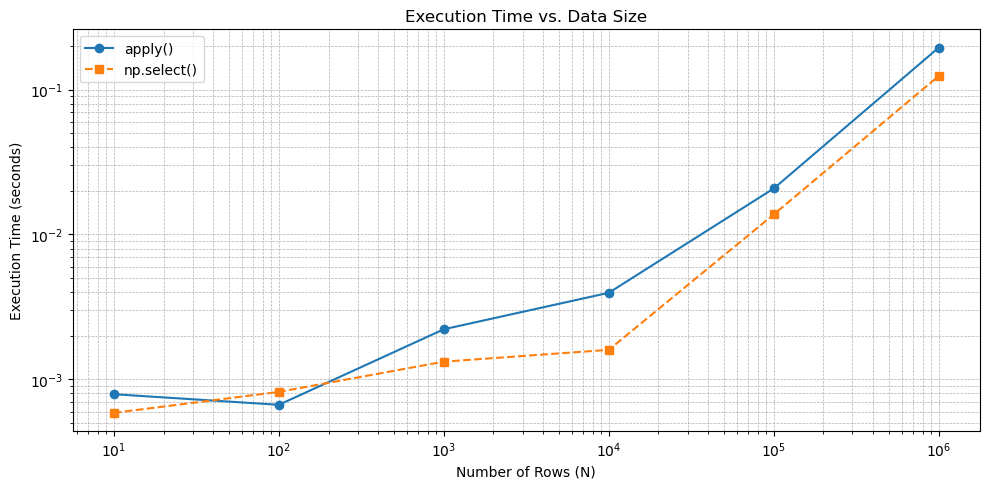

In [22]:
# Executa o benchmark e plota o gráfico
benchmark_plot_apply_vs_npselect(
    sizes=[10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 5),
    log_scale=True
)